# IROP Project 

This project was conducted during the summer of 2025, further details are provided here: https://john-zou-pek.github.io/projects/IROP_project_2025

## Node generation:

The following implements the graph model linked above, with $N$ the number of nodes. This returns a list of coordinates for the nodes in the 2-d unit square.

In [ ]:
import numpy as np


#Generates N nodes and returns an array of tuples of their position.
def N_node_gen(N):
    '''
    The function generates N nodes with random positions in a 2D space.
    Each node's position is represented as a numpy array with two elements (x, y),
    where both x and y are random floats between 0 and 1.
    The function returns a list of these numpy arrays.
    ---
    N: the number of nodes to generate.
    ---
    Returns the list of node positions as numpy arrays.
    '''
    node_list = list()
    for _ in range(N):
        node_list.append(np.array((np.random.random(), np.random.random())))
    return node_list

test_nodes = N_node_gen(5)
test_nodes

[array([0.0421106, 0.6800219]),
 array([0.98255025, 0.44960471]),
 array([0.41102061, 0.01796213]),
 array([0.1754504 , 0.60154416]),
 array([0.49485246, 0.84399078])]

## Original Model

The following implements the original model for simulation. This is only used at the end when studying commincation cost.

In [ ]:
def original_adj_mat(node_list, R):
    '''
    The function computes the adjacency matrix for a set of nodes based on a given radius R.
    It creates a square matrix where the element at (i, j) is 1 if the distance between node i and node j is less than R,
    and 0 otherwise.
    The function iterates through all pairs of nodes, calculates the Euclidean distance between them,
    and fills the adjacency matrix accordingly.
    node_list: a list of numpy arrays representing the positions of the nodes.
    ---
    R: the radius within which nodes are considered connected.
    ---
    Returns the adjacency matrix as a numpy array.
    '''
    N = len(node_list)
    adj_mat = np.zeros((N, N), dtype=np.float64)
    for i in range(N):
        for j in range(i+1, N):
            dist = np.linalg.norm(node_list[i]-node_list[j])
            if dist < R:
                adj_mat[i, j] = 1
                adj_mat[j, i] = 1
    return adj_mat

In [ ]:
def original_W_i_gen(i, adj_mat, gamma):
    '''
    The function generates the iterative matrix W_i used to update the state of nodes given
    the node i is broadcasting.
    ---
    i: the index of the broadcasting node (1-indexed).
    adj_mat: the adjacency matrix representing the connections between nodes.
    gamma: the mixing parameter of the current algorithm.
    ---
    Returns the W_i matrix.
    '''
    i -= 1
    W_i = np.zeros(np.shape(adj_mat), dtype=np.float64)
    N = np.shape(adj_mat)[0]
    for j in range(N):
        if adj_mat[i, j]:
            W_i[j, j] = 1 - gamma
            W_i[j, i] = gamma
        else:
            W_i[j, j] = 1
    return W_i

In [ ]:
def original_update_step(x, adj_mat, gamma):
    '''
    The function performs an update step for the state vector x(t) using the original model.
    It randomly selects a node to broadcast, generates the corresponding W_i matrix,
    and updates the state vector by multiplying it with W_i.
    ---
    x: the current state vector x(t).
    adj_mat: the adjacency matrix of the graph.
    ---
    Returns x(t+1)
    '''
    N = len(x)
    i = np.random.randint(N, size=1)
    W_i = original_W_i_gen(i, adj_mat, gamma)
    return np.matmul(W_i, x)

In [ ]:
def original_simulate(x_0, adj_mat, gamma, time):
    '''
    The function simulates the evolution of the state vector x over a specified number of time steps
    using the original update step function.
    It initializes a list to store the state vectors at each time step, starting with the initial state x_0.
    For each time step, it applies the original update step function to the last state vector in the list,
    appends the new state vector to the list, and finally returns the list as a numpy array.
    ---
    x_0: the initial state vector.
    adj_mat: the adjacency matrix of the graph.
    gamma: the mixing parameter of the current algorithm.
    time: the number of time steps to simulate.
    ---
    Returns an array of state vectors at each time step.
    '''
    x_list = [x_0]
    for t in range(1, time+1):
        x_list.append(original_update_step(x_list[-1], adj_mat, gamma))
    return np.array(x_list)

## Generalisation to Weighted Graph

The following produces illustrations for weighted graphs with the following rule:

Suppose the euclidian distance between two nodes is $d < R$ then the weight between the two nodes is given by $1-\frac{d}{R}$ for $R$ the radius defined in the full set of notes. 

In [ ]:
import numpy as np

#Returns adjacency matrix of the generated graph

def adj_mat_gen(node_list, R):
    '''
    The function computes a weighted adjacency matrix for a set of nodes based on a given radius R.
    It creates a square matrix where the element at (i, j) is a weight calculated as provided above.
    The function iterates through all pairs of nodes, calculates the Euclidean distance between them,
    and fills the adjacency matrix accordingly.
    ---
    node_list: a list of numpy arrays representing the positions of the nodes.
    R: the radius within which nodes are considered connected.
    ---
    Returns the weighted adjacency matrix as a numpy array.
    '''
    N = len(node_list)
    adj_mat = np.zeros((N, N), dtype=np.float64)
    for i in range(N):
        for j in range(i+1, N):
            dist = np.linalg.norm(node_list[i]-node_list[j])
            if dist < R:
                adj_mat[i, j] = 1 - dist/R
                adj_mat[j, i] = 1 - dist/R
    return adj_mat

test_adj_mat = adj_mat_gen(test_nodes, 0.5)

test_adj_mat

array([[0.        , 0.0427497 , 0.        , 0.        , 0.        ],
       [0.0427497 , 0.        , 0.        , 0.        , 0.84130046],
       [0.        , 0.        , 0.        , 0.        , 0.10601608],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.84130046, 0.10601608, 0.        , 0.        ]])

In [ ]:
#Produces the matrix W(i)

def W_i_gen(i, adj_mat, gamma):
    '''
    The function generates the iterative matrix W_i used to update the state of nodes given
    the node i is broadcasting.
    ---
    i: the index of the broadcasting node (1-indexed).
    adj_mat: the adjacency matrix representing the connections between nodes.
    gamma: the mixing parameter of the current algorithm.
    ---
    Returns the W_i matrix.'''
    i -= 1
    W_i = np.zeros(np.shape(adj_mat), dtype=np.float64)
    N = np.shape(adj_mat)[0]
    for j in range(N):
        if adj_mat[i, j]:
            val = adj_mat[i, j].item()
            W_i[j, j] = 1 - gamma * val
            W_i[j, i] = gamma * val
        else:
            W_i[j, j] = 1
    return W_i

test_W_1 = W_i_gen(1, test_adj_mat, 0.5)

test_W_1

array([[1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.02137485, 0.97862515, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ]])

In [ ]:
#A single step of the simulation

def update_step(x, adj_mat, gamma):
    '''
    The function performs an update step for the state vector x(t).
    It randomly selects a node to broadcast, generates the corresponding W_i matrix,
    and updates the state vector by multiplying it with W_i.
    ---
    x: the current state vector x(t).
    adj_mat: the adjacency matrix of the graph.
    gamma: the mixing parameter of the current algorithm.
    ---
    Returns x(t+1)
    '''
    N = len(x)
    i = np.random.randint(N, size=1)
    W_i = W_i_gen(i, adj_mat, gamma)
    return np.matmul(W_i, x)

test_x = np.random.random(size=5)
update_step(test_x, test_adj_mat, 0.5)

array([0.09305588, 0.88338869, 0.1326691 , 0.32456046, 0.95092261])

In [ ]:
import numpy as np

def simulate(x_0, adj_mat, gamma, time):
    '''
    The function simulates the evolution of the state vector x over a specified number of time steps.
    It initializes a list to store the state vectors at each time step, starting with the initial state x_0.
    For each time step, it applies the update step function to the last state vector in the list,
    appends the new state vector to the list, and finally returns the list as a numpy array.
    ---
    x_0: the initial state vector.
    adj_mat: the adjacency matrix of the graph.
    gamma: the mixing parameter of the current algorithm.
    time: the number of time steps to simulate.
    ---
    Returns an array of state vectors at each time step.
    '''
    x_list = [x_0]
    for t in range(1, time+1):
        x_list.append(update_step(x_list[-1], adj_mat, gamma))
    return np.array(x_list)

test_x = np.random.random(size=5)
test_simulation = simulate(test_x, test_adj_mat, 0.5, 10)
test_simulation

array([[0.50733494, 0.01840146, 0.9242673 , 0.7495847 , 0.72859206],
       [0.49688406, 0.01840146, 0.9242673 , 0.7495847 , 0.42985022],
       [0.49688406, 0.19147747, 0.89805922, 0.7495847 , 0.42985022],
       [0.49688406, 0.19147747, 0.89805922, 0.7495847 , 0.42985022],
       [0.49035603, 0.19147747, 0.89805922, 0.7495847 , 0.32957867],
       [0.49035603, 0.19147747, 0.89805922, 0.7495847 , 0.35971271],
       [0.49035603, 0.19147747, 0.89805922, 0.7495847 , 0.3882494 ],
       [0.49035603, 0.19147747, 0.89805922, 0.7495847 , 0.41527342],
       [0.49035603, 0.19786596, 0.89805922, 0.7495847 , 0.41527342],
       [0.49035603, 0.20411789, 0.89805922, 0.7495847 , 0.41527342],
       [0.49035603, 0.20411789, 0.89805922, 0.7495847 , 0.41527342]])

In [240]:
N = 50
R = 2*np.sqrt(np.log(N)/N)
time = 1000
gamma = 0.5
sim_num = 1000

node_list = N_node_gen(N)
adj_mat = adj_mat_gen(node_list, R)

x_0 = np.random.random(N)

In [241]:
#Convergence in expectation data generation

desired_x = np.mean(x_0) * np.ones(N)

node_list = N_node_gen(N)
adj_mat = adj_mat_gen(node_list, R)

t_array = np.array([_ for _ in range(time+1)])
x_array = np.zeros((time+1, N))
beta_matrix = np.identity(N) - 1/N * np.ones((N, N))
beta_arr = np.zeros((time+1, N), dtype=np.float64)

total_beta_arr = np.zeros(time+1, dtype=np.float64)

for _ in range(sim_num):
    output = simulate(x_0, adj_mat, gamma, time)
    x_array += output
    for i in range(time+1):
        beta_arr[i] = beta_matrix@output[i]
    total_beta_arr += np.linalg.norm(beta_arr, axis=1) ** 2

x_array /= sim_num
x_array -= desired_x

plot_vals = np.linalg.norm(x_array, axis=1)

plot_vals_2 = total_beta_arr / sim_num

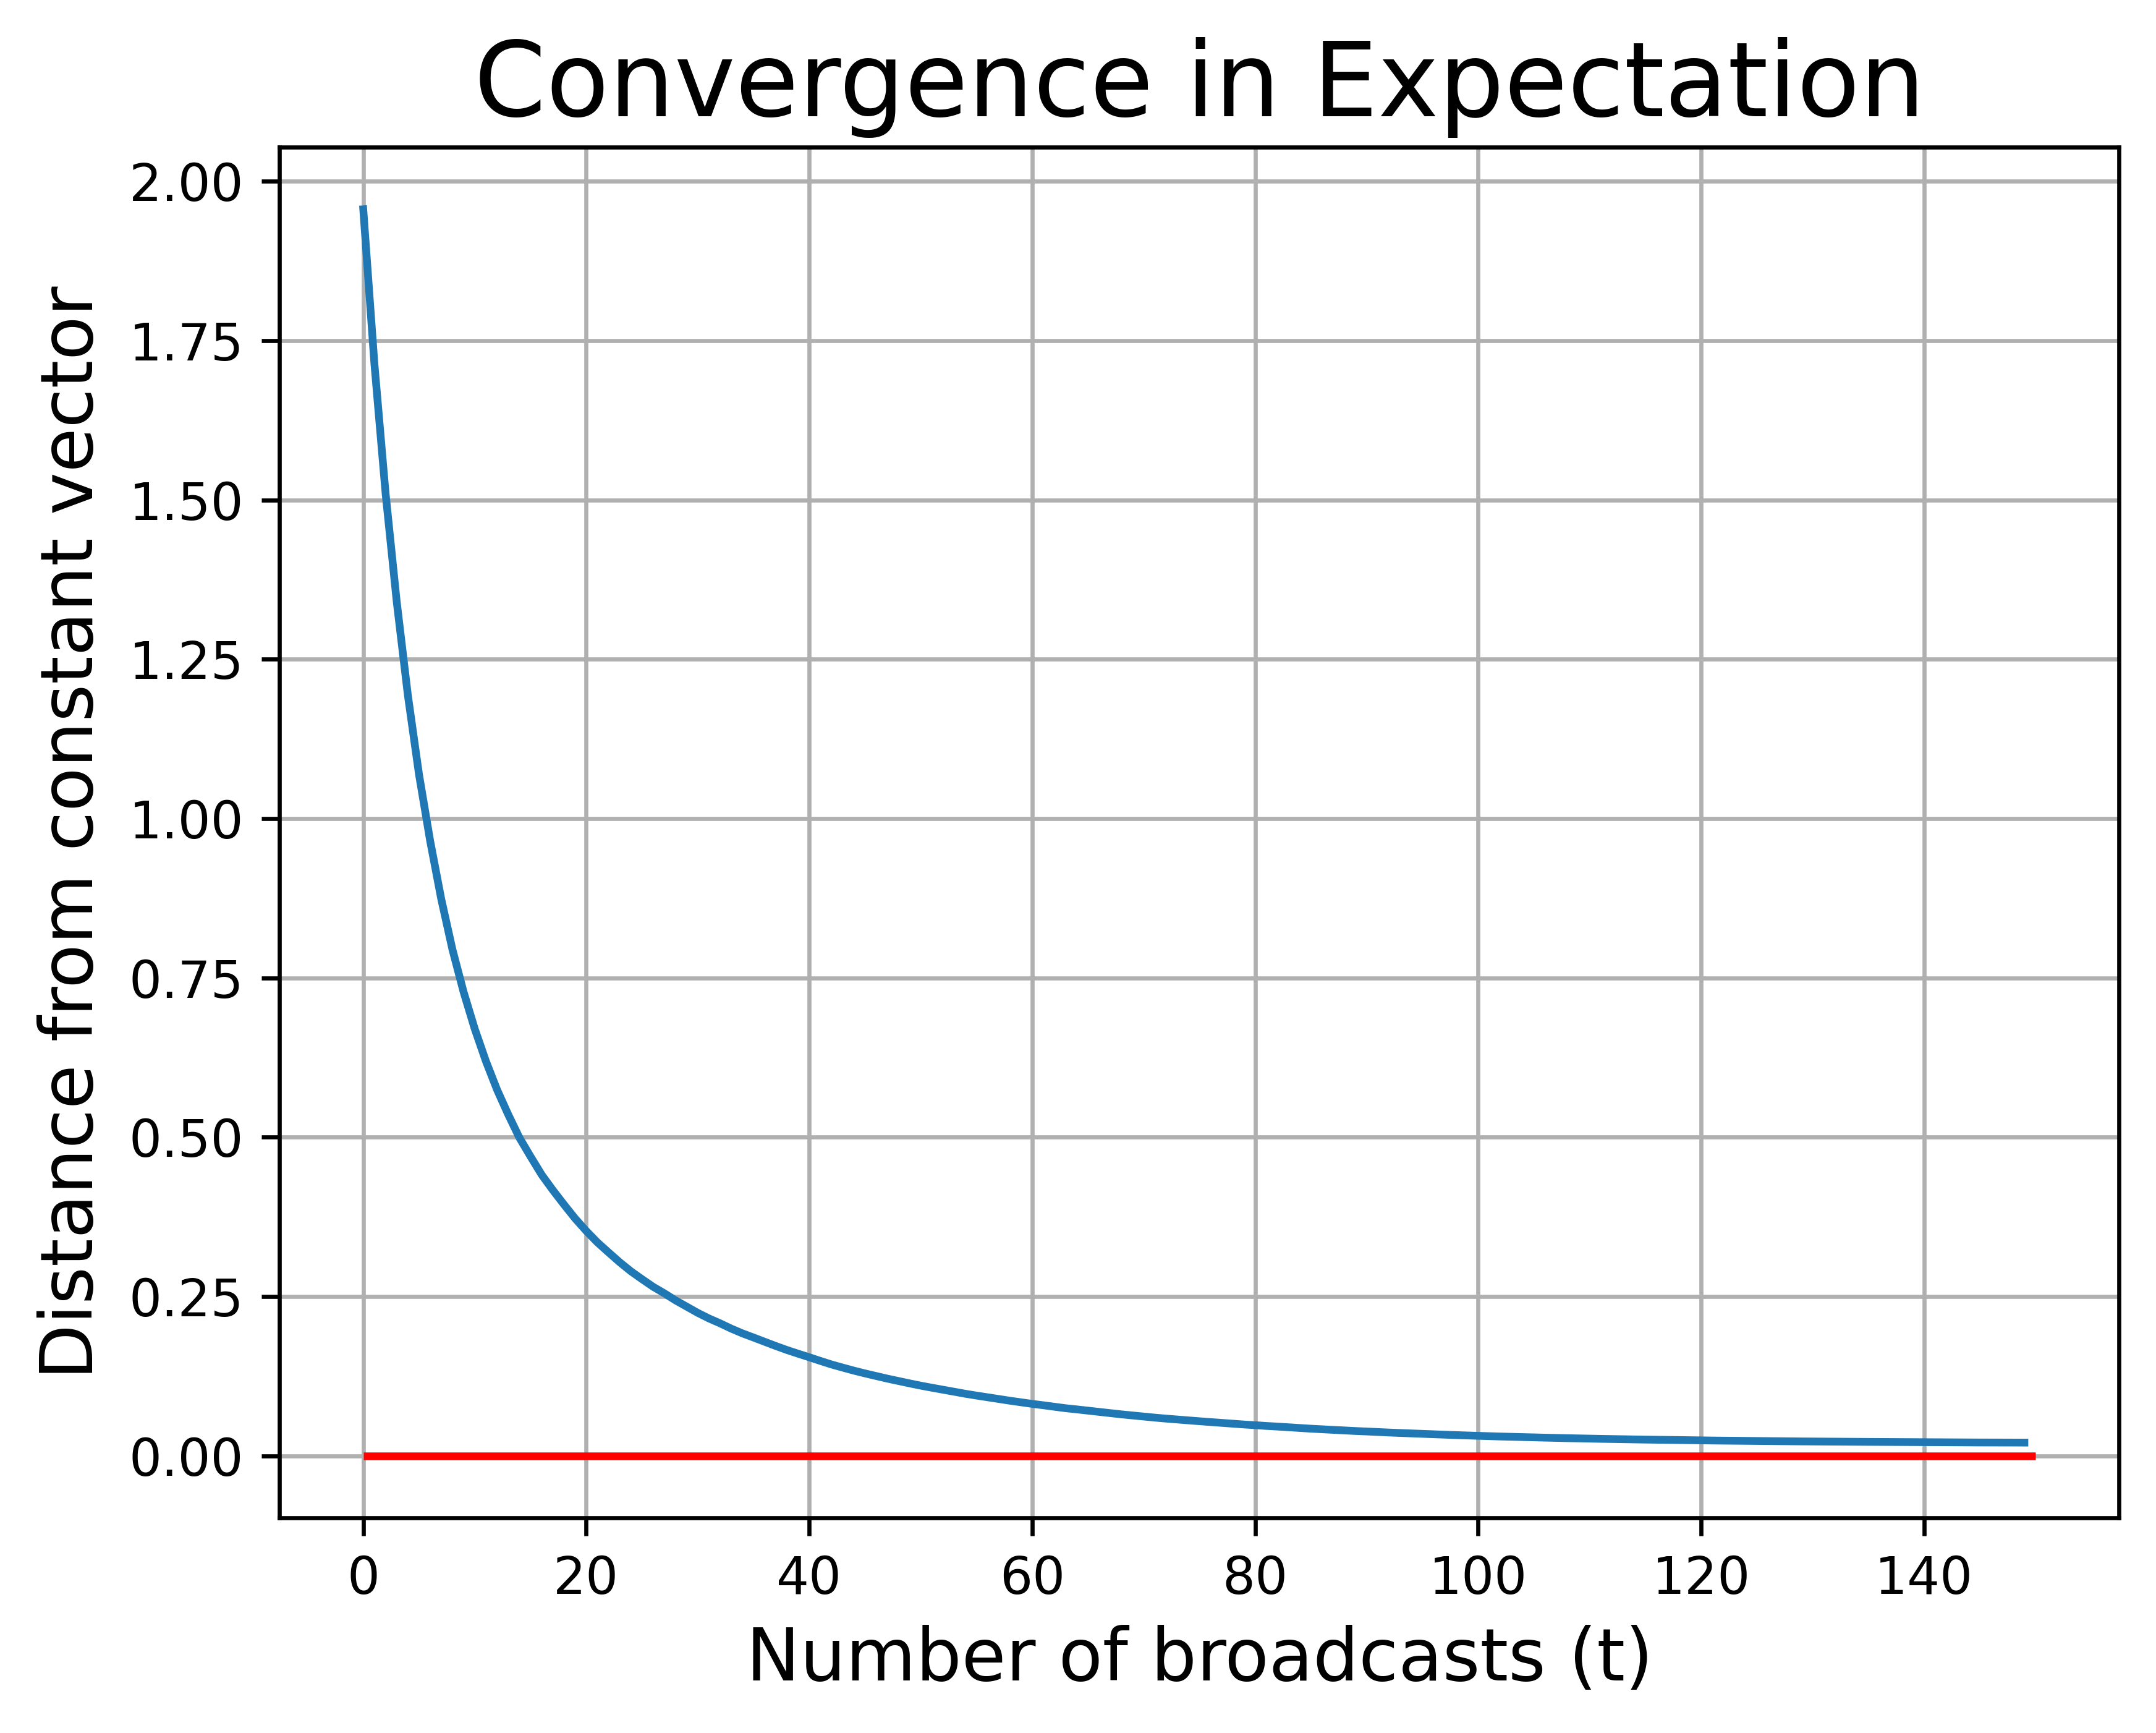

In [242]:
#Convergence in expectation plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(t_array[0:150], plot_vals[0:150])
ax.hlines(0, 0, 150, colors='r')
ax.grid(True)
ax.set_xlabel("Number of broadcasts (t)", fontsize=14)
ax.set_ylabel("Distance from constant vector", fontsize=14)
ax.set_title("Convergence in Expectation", fontsize=20)
fig.set_dpi(600)

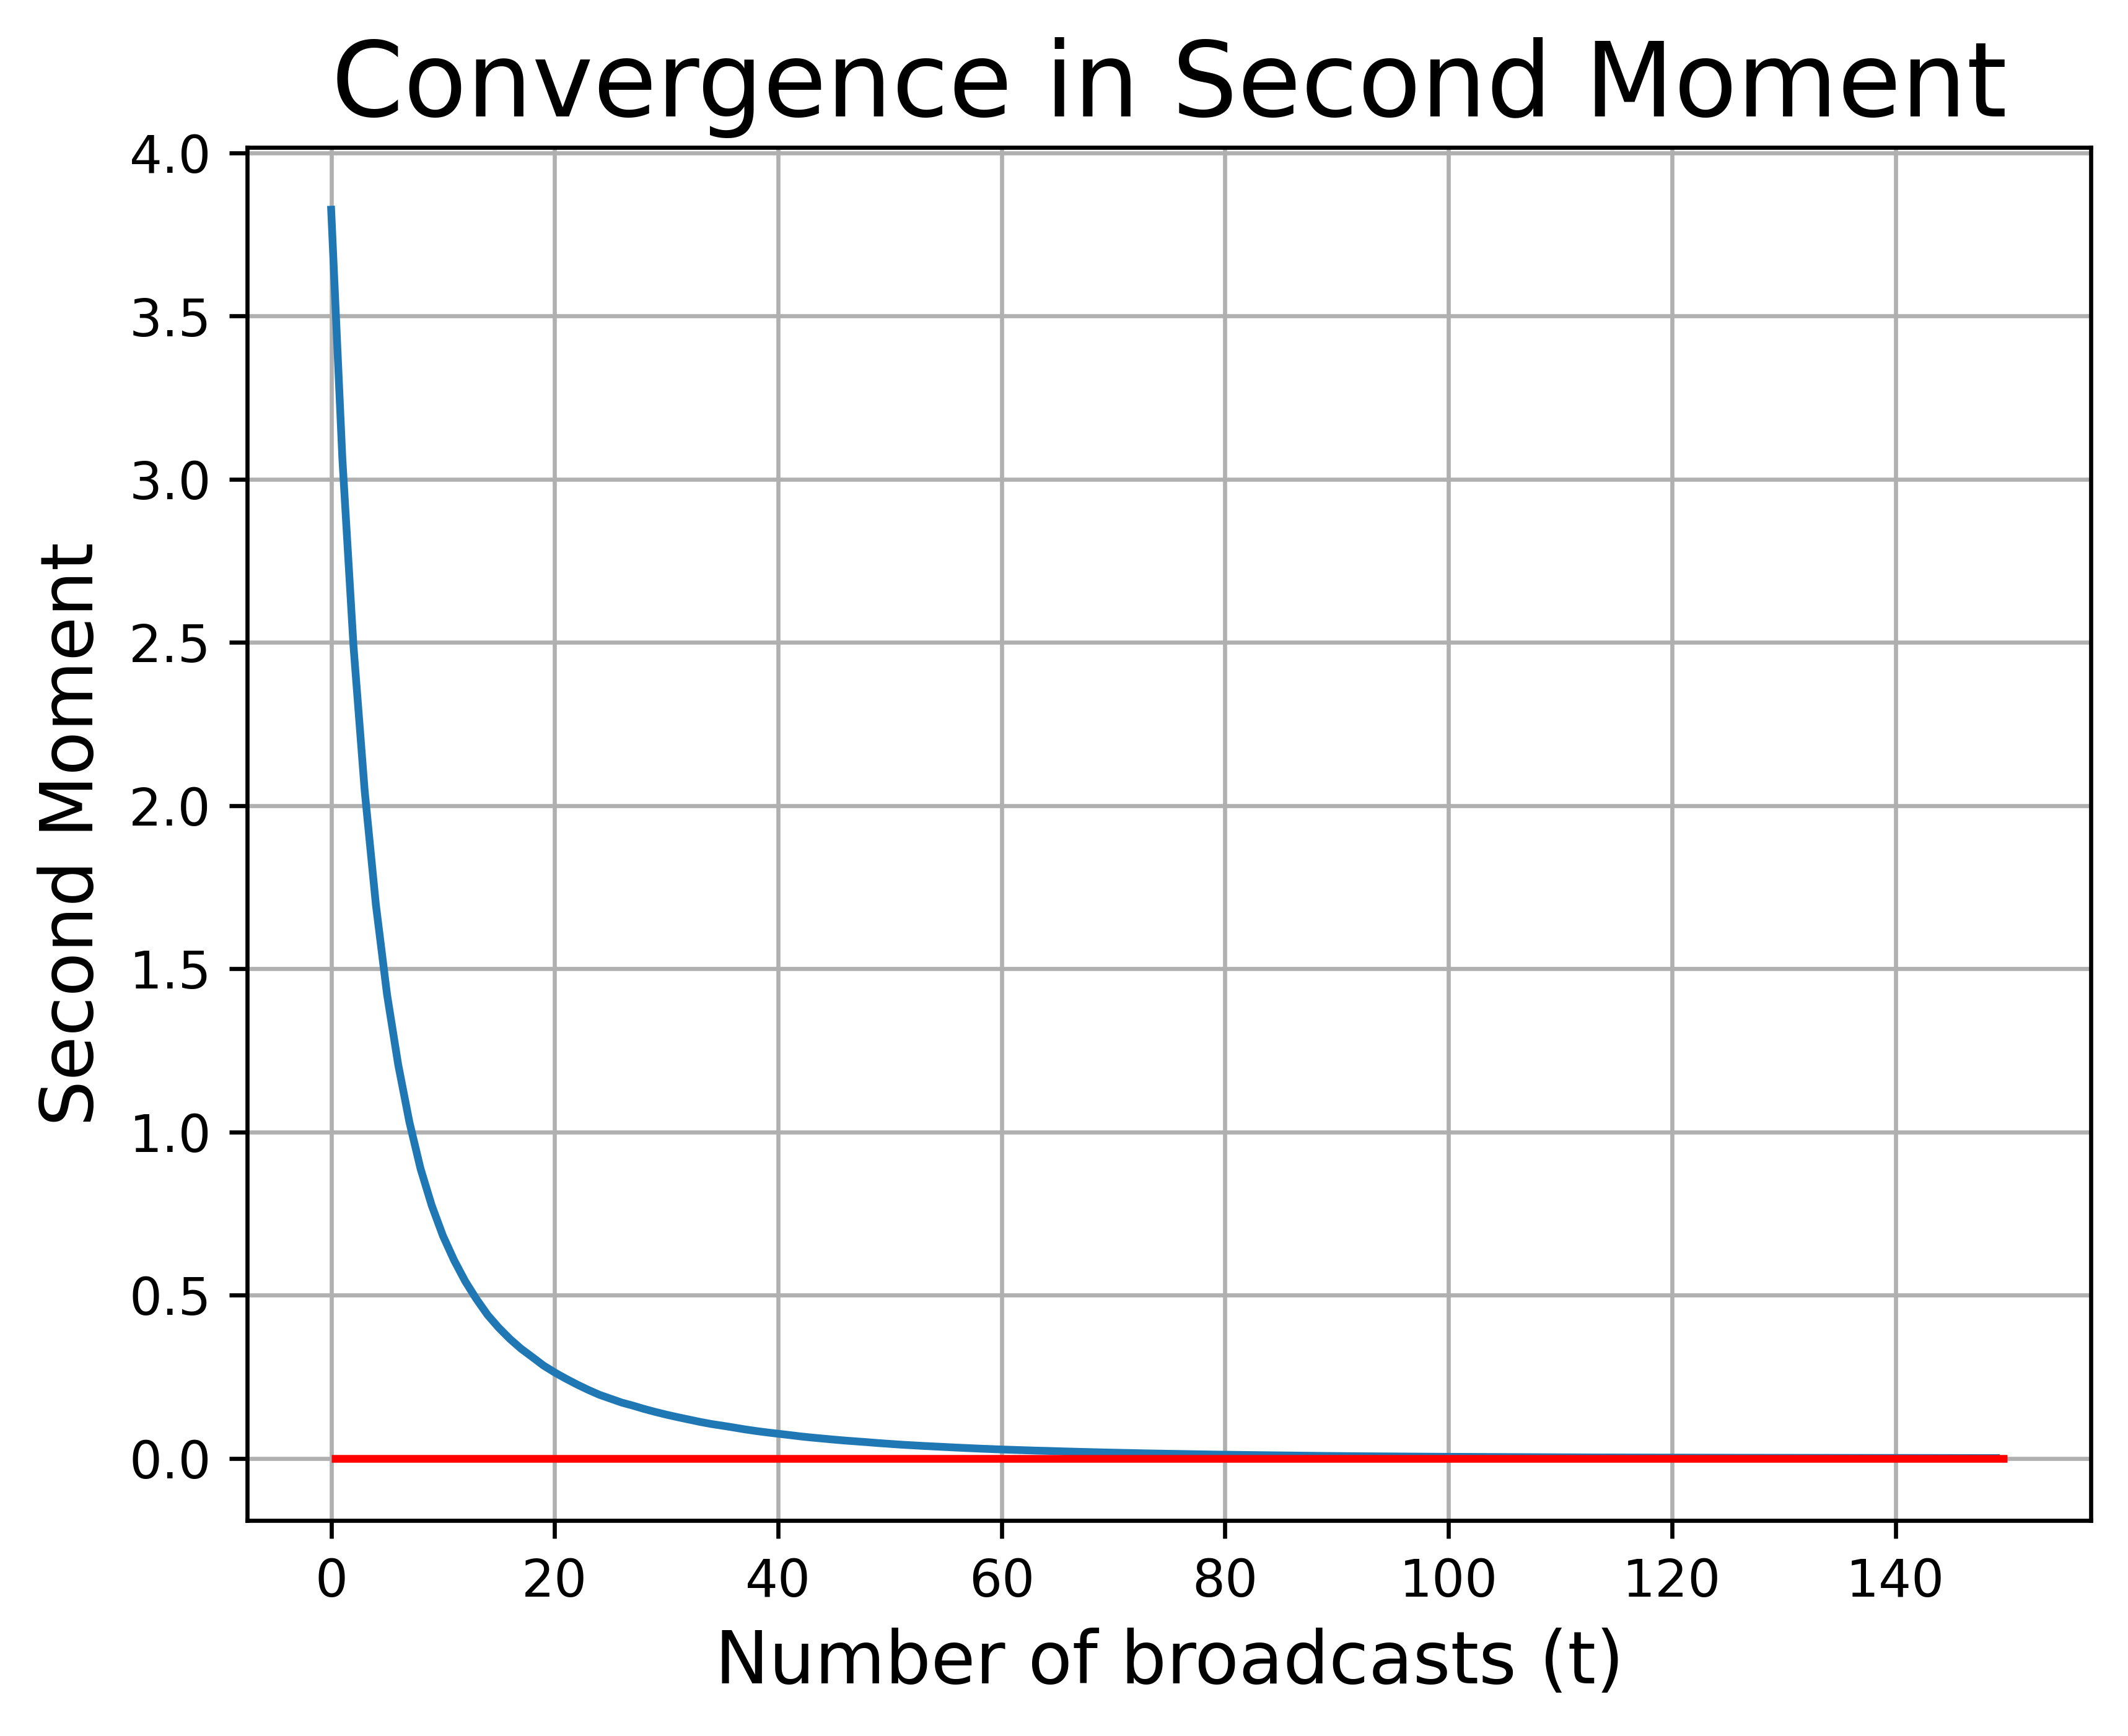

In [243]:
#Convergence in second moment plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(t_array[0:150], plot_vals_2[0:150])
ax.hlines(0, 0, 150, colors='r')

ax.grid(True)
ax.set_xlabel("Number of broadcasts (t)", fontsize=14)
ax.set_ylabel("Second Moment", fontsize=14)
ax.set_title("Convergence in Second Moment", fontsize=20)
fig.set_dpi(600)

## Generalisation to Stochastic Mixing Parameter

In [244]:
def indep_stoch_sim(x_0, adj_mat, gam, time):
    x_list = [x_0]
    for t in range(1, time+1):
        gamma = np.random.uniform(0, gam)
        x_list.append(update_step(x_list[-1], adj_mat, gamma))
    return np.array(x_list)

In [245]:
N = 50
R = 2*np.sqrt(np.log(N)/N)
time = 1000
gam = 1

node_list = N_node_gen(N)
adj_mat = adj_mat_gen(node_list, R)

x_0 = np.random.random(N)

In [246]:
#Convergence in expectation data generation

desired_x = np.mean(x_0) * np.ones(N)

node_list = N_node_gen(N)
adj_mat = adj_mat_gen(node_list, R)

t_array = np.array([_ for _ in range(time+1)])
x_array = np.zeros((time+1, N))
beta_matrix = np.identity(N) - 1/N * np.ones((N, N))
beta_arr = np.zeros((time+1, N), dtype=np.float64)

total_beta_arr = np.zeros(time+1, dtype=np.float64)

for _ in range(sim_num):
    output = indep_stoch_sim(x_0, adj_mat, gam, time)
    x_array += output
    for i in range(time+1):
        beta_arr[i] = beta_matrix@output[i]
    total_beta_arr += np.linalg.norm(beta_arr, axis=1) ** 2

x_array /= sim_num
x_array -= desired_x

plot_vals_indep_1 = np.linalg.norm(x_array, axis=1)

plot_vals_indep_2 = total_beta_arr / sim_num


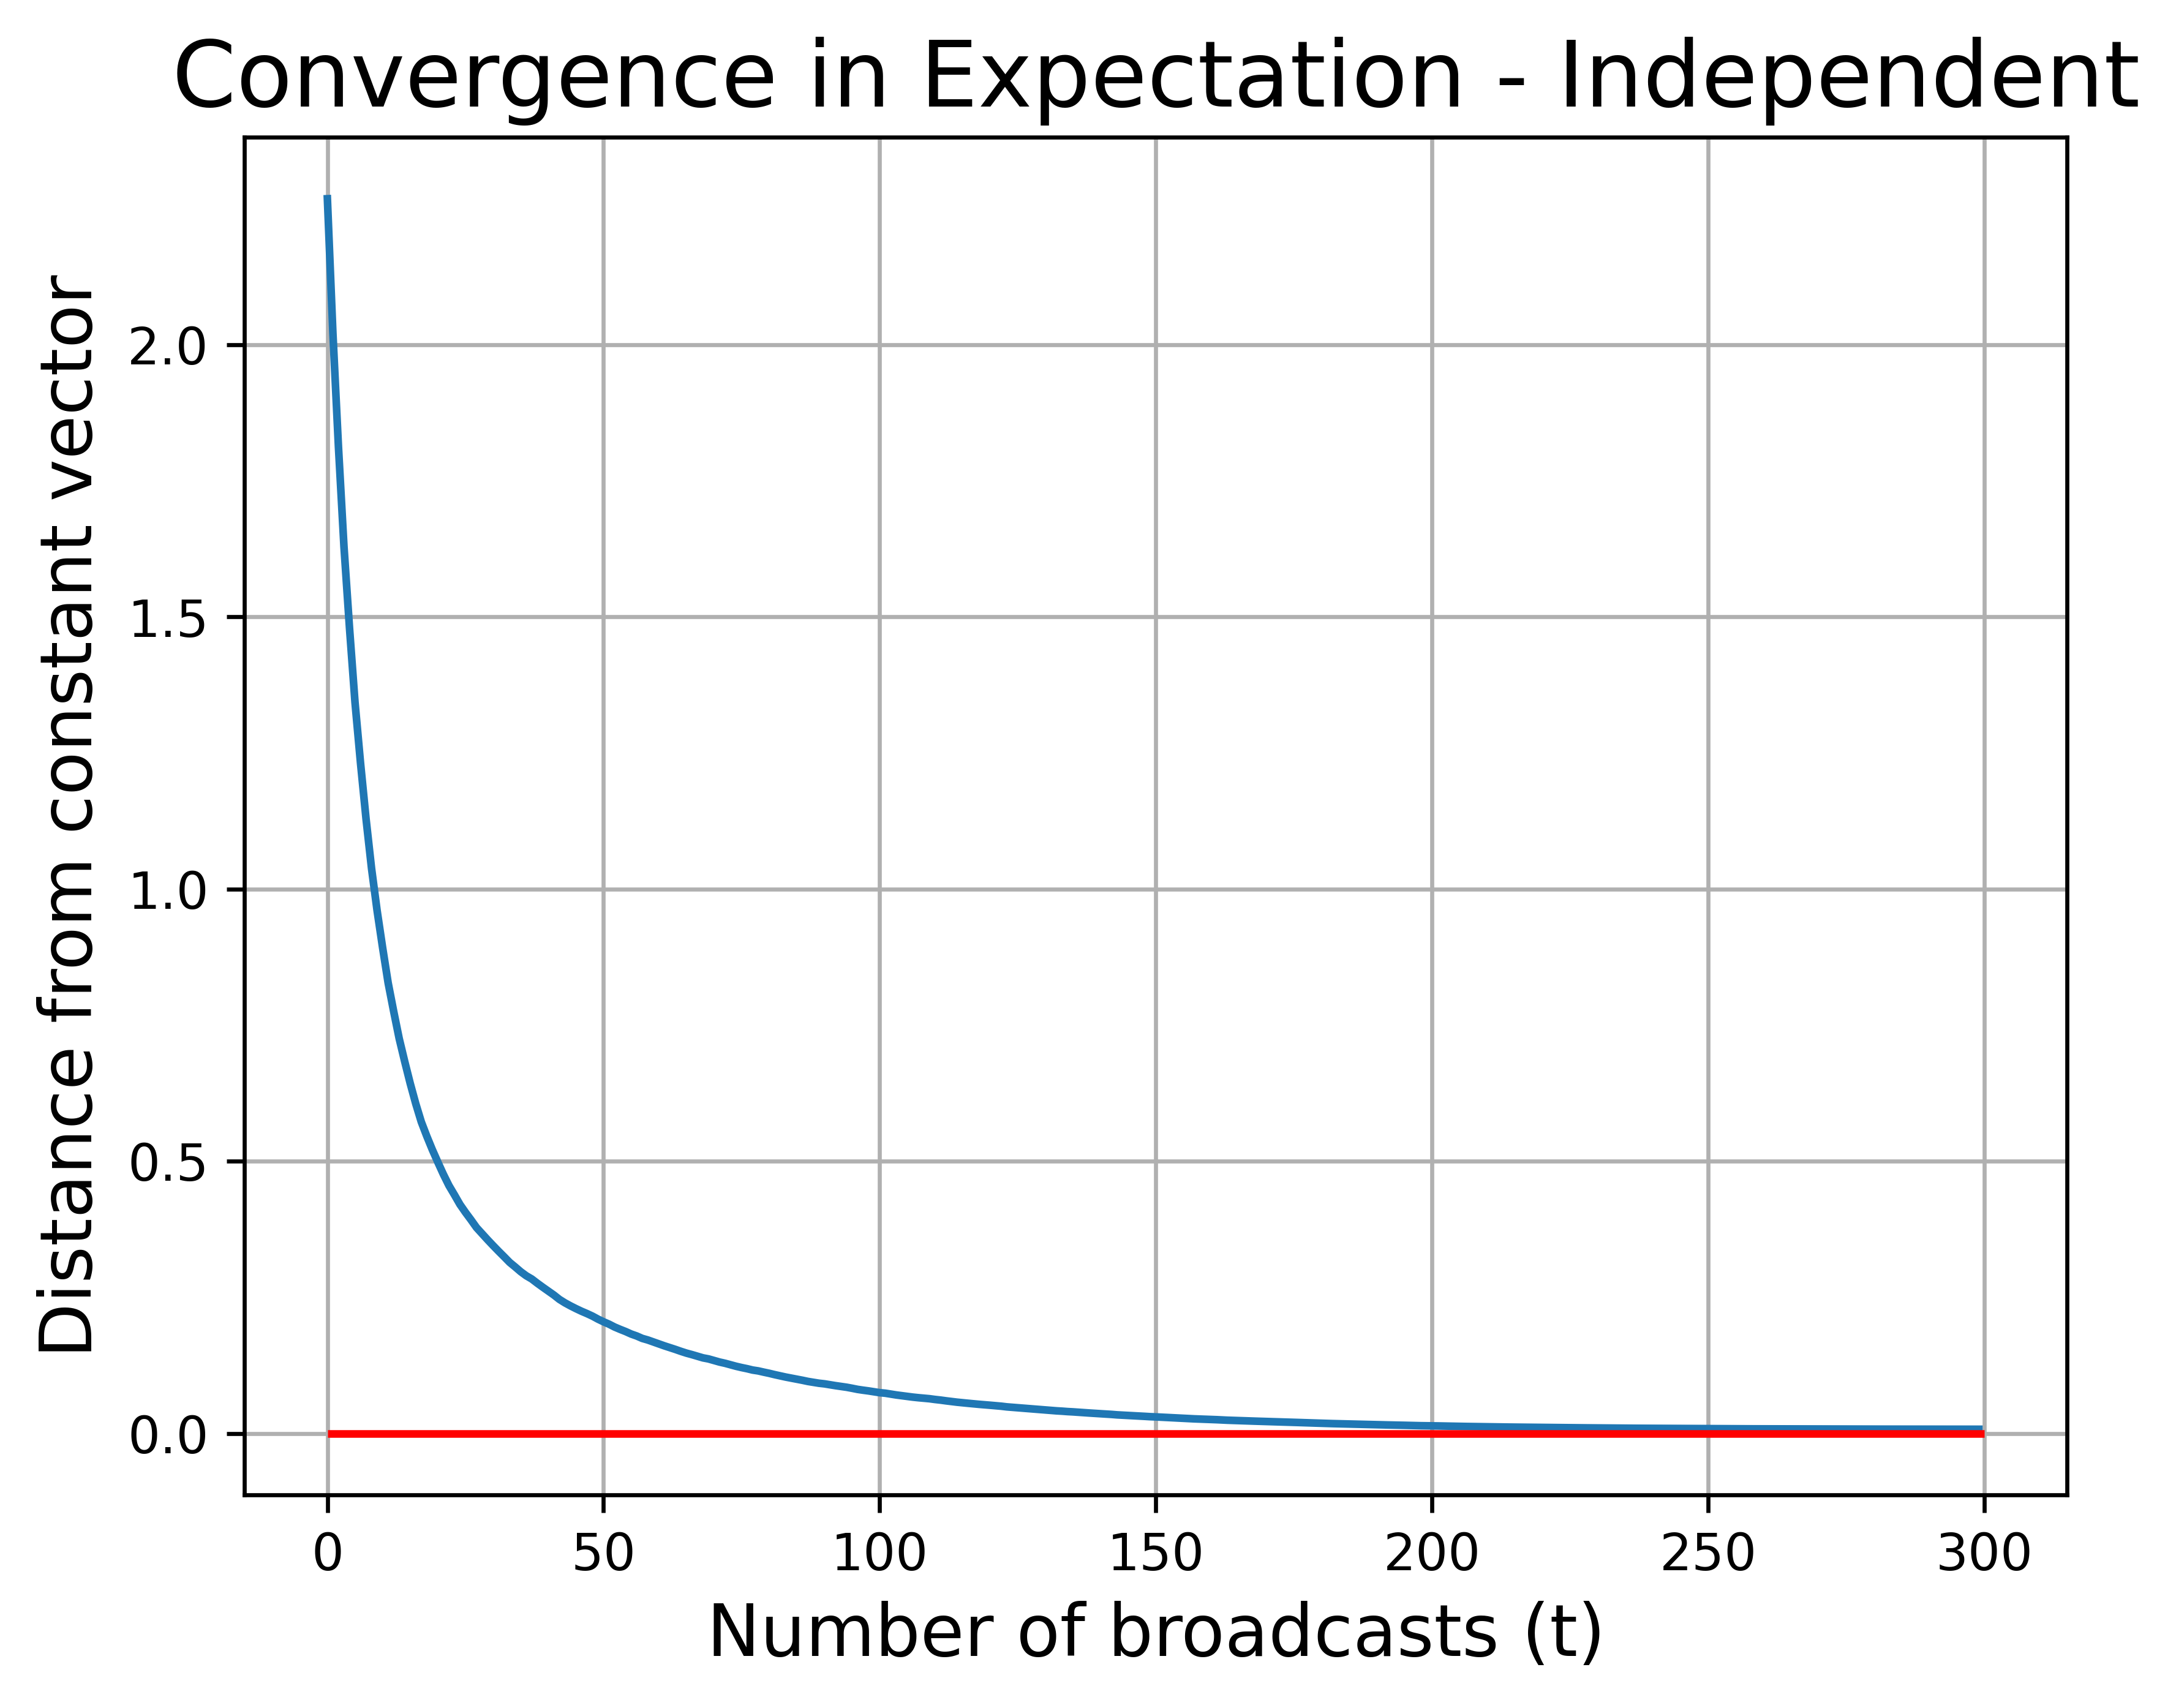

In [247]:
# Convergence in expectation plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(t_array[0:300], plot_vals_indep_1[0:300])
ax.hlines(0, 0, 300, colors='r')
ax.grid(True)
ax.set_xlabel("Number of broadcasts (t)", fontsize=14)
ax.set_ylabel("Distance from constant vector", fontsize=14)
ax.set_title("Convergence in Expectation - Independent", fontsize=18)
fig.set_dpi(600)

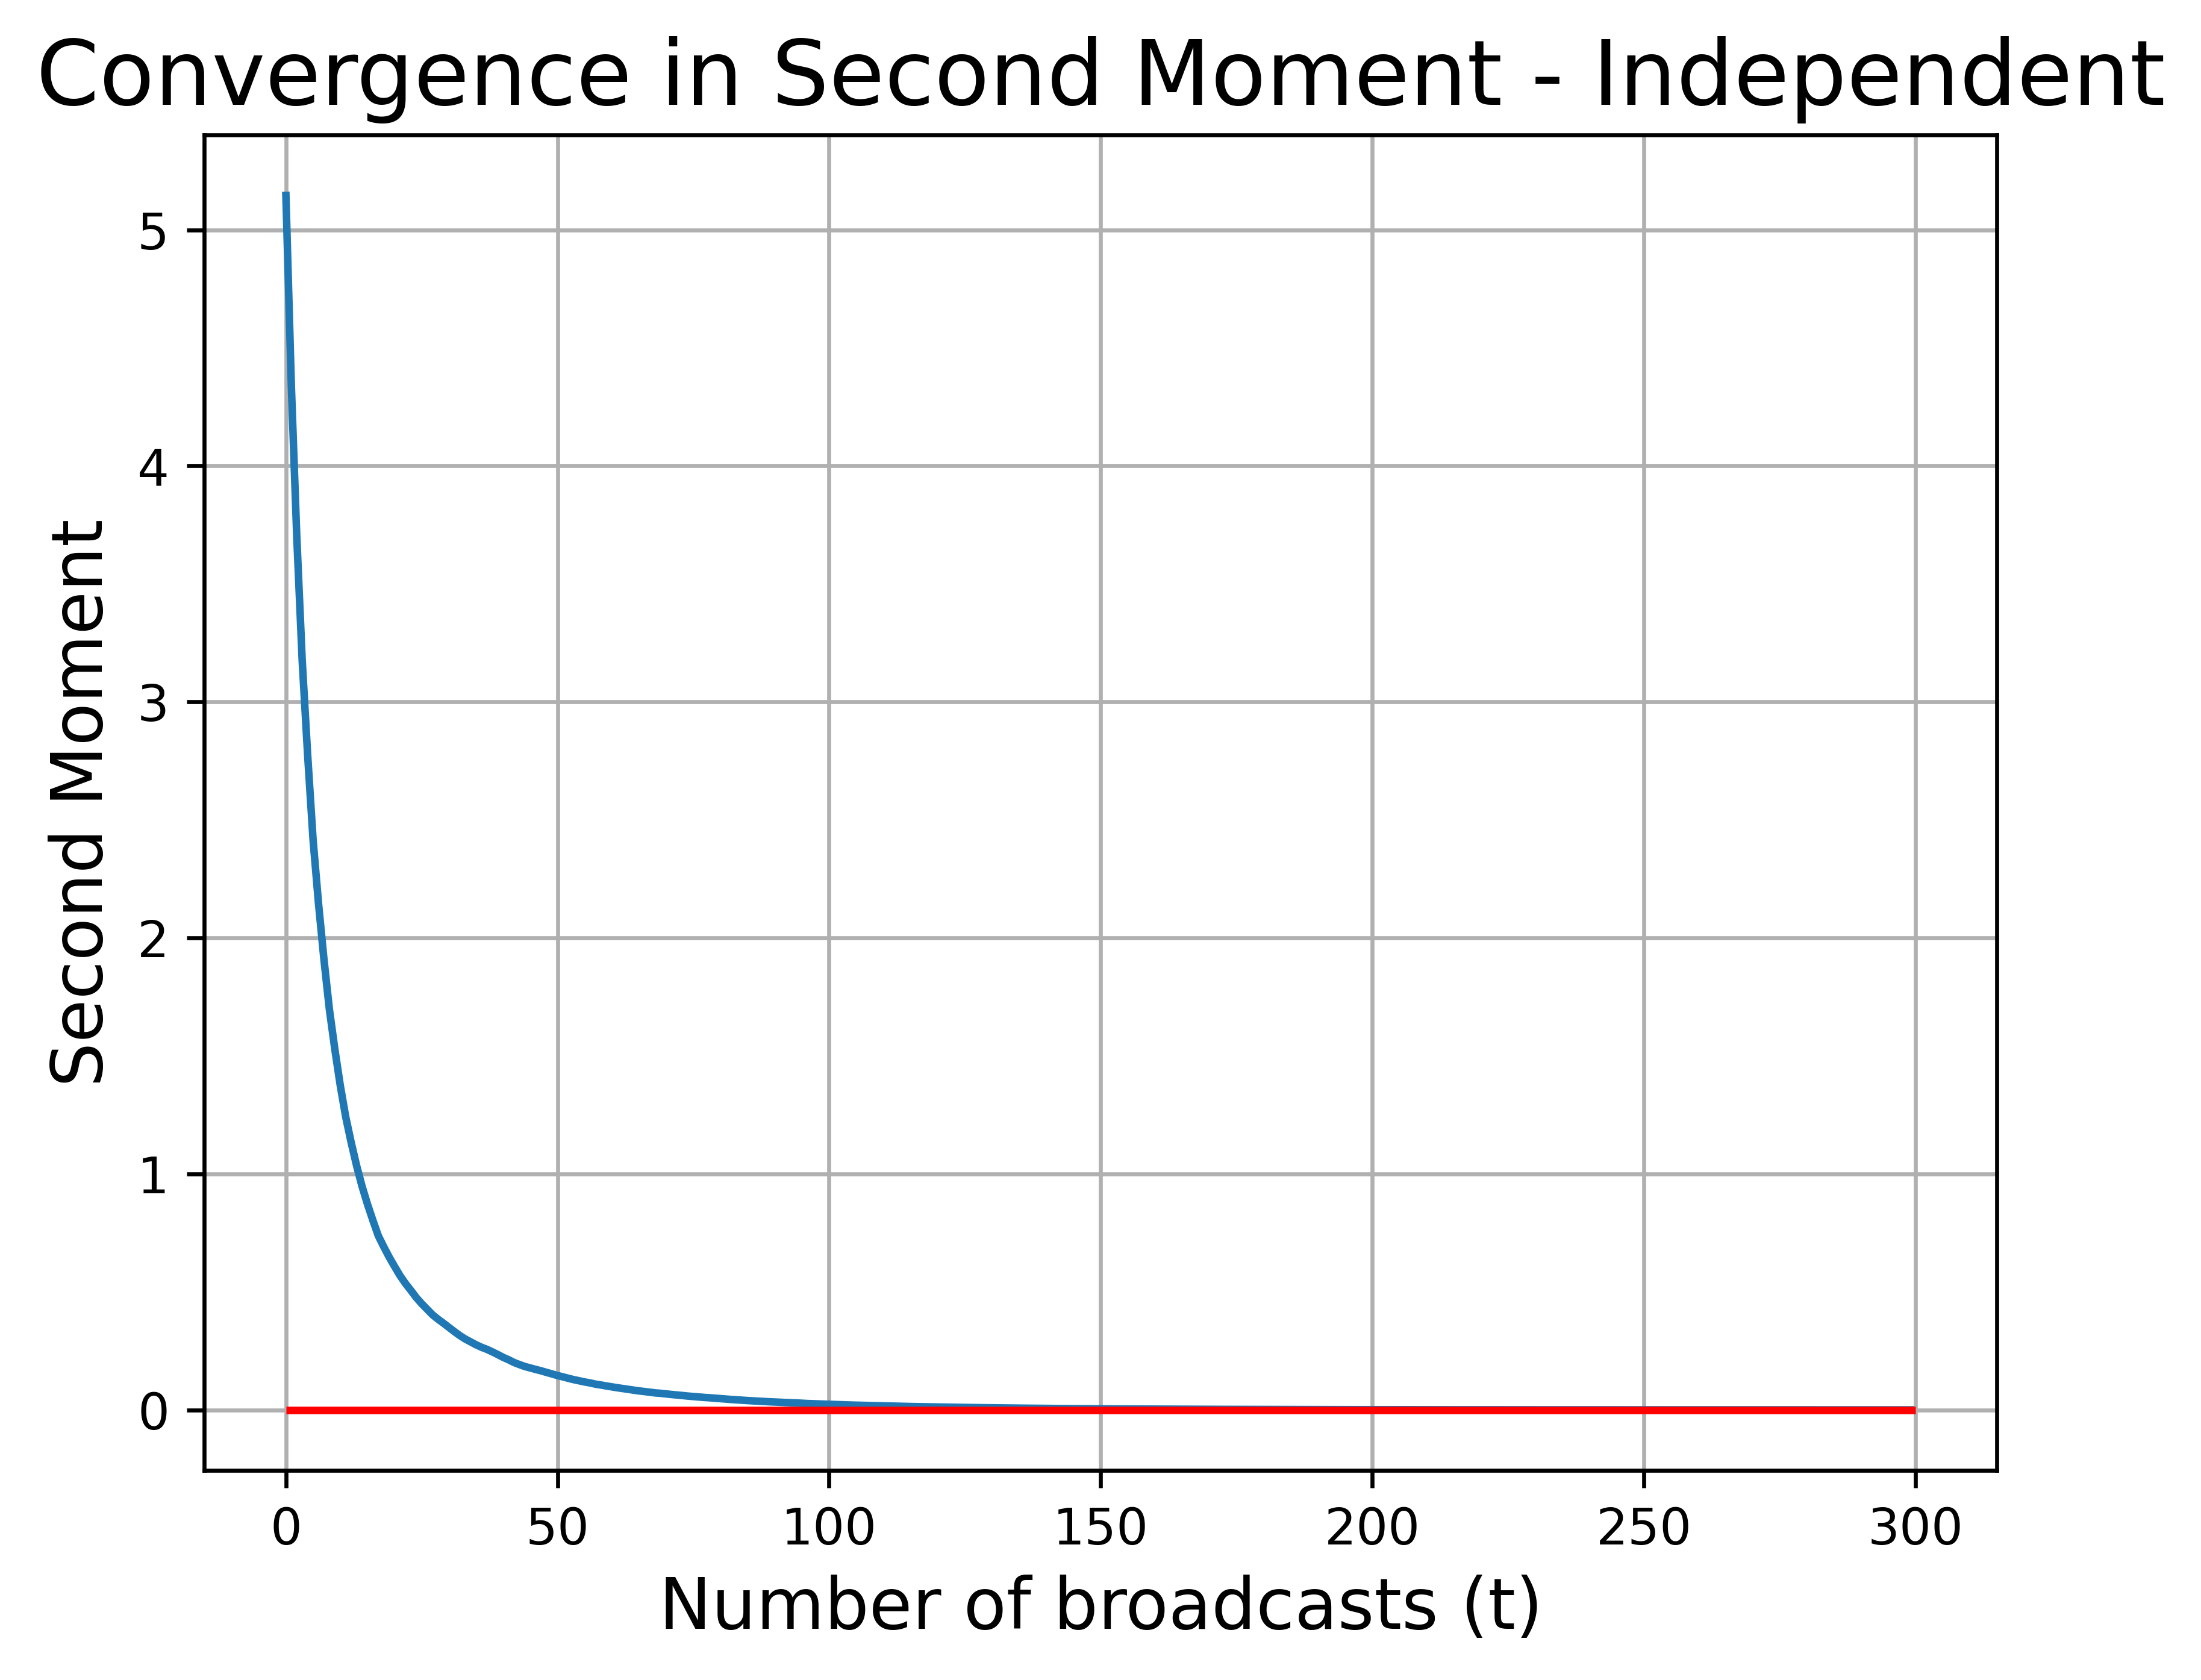

In [248]:
#Convergence in second moment plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(t_array[0:300], plot_vals_indep_2[0:300])
ax.hlines(0, 0, 300, colors='r')

ax.grid(True)
ax.set_xlabel("Number of broadcasts (t)", fontsize=14)
ax.set_ylabel("Second Moment", fontsize=14)
ax.set_title("Convergence in Second Moment - Independent", fontsize=18)
fig.set_dpi(600)

## Generalisation to Dependent Stochastic Mixing Parameter

In [249]:
#A single step of the simulation

def dep_update_step(x, adj_mat, gam_dict):
    N = len(x)
    i = np.random.randint(N, size=1)
    gamma = np.random.uniform(0, gam_dict[i[0]])
    W_i = W_i_gen(i, adj_mat, gamma)
    return np.matmul(W_i, x)

In [250]:
import numpy as np

def dep_stoch_sim(x_0, adj_mat, gam_dict, time):
    x_list = [x_0]
    for t in range(1, time+1):
        x_list.append(dep_update_step(x_list[-1], adj_mat, gam_dict))
    return np.array(x_list)

In [251]:
import networkx as nx

sim_num = 1000
N = 50
R = 2*np.sqrt(np.log(N)/N)
time = 1000

node_list = N_node_gen(N)
adj_mat = adj_mat_gen(node_list, R)

G = nx.from_numpy_array(adj_mat)
gam_dict = nx.pagerank(G)

maxval = max(gam_dict.values())
gam_dict = {key: value/maxval for key, value in gam_dict.items()}

x_0 = np.random.random(N)

gam_dict

{0: 0.6192265630664029,
 1: 0.6545375239787041,
 2: 0.6050033634896528,
 3: 0.910726816835588,
 4: 0.716020931890455,
 5: 0.7280184601967162,
 6: 0.7956276589716283,
 7: 0.7572430249248602,
 8: 0.633903454284291,
 9: 0.7023169217359181,
 10: 0.7547457541326233,
 11: 0.7777284224048506,
 12: 0.9595118124475277,
 13: 0.8643770211320655,
 14: 0.9545693353317725,
 15: 0.8731093976780911,
 16: 0.5453202331992676,
 17: 0.9193621592840233,
 18: 0.7845768762561262,
 19: 0.8041128977658275,
 20: 0.9670006321490067,
 21: 0.8676790459761691,
 22: 0.788509669438317,
 23: 0.8076594332510967,
 24: 0.90257751744085,
 25: 1.0,
 26: 0.9352304669853587,
 27: 0.7393262190023526,
 28: 0.8654495351320661,
 29: 0.9336377005000736,
 30: 0.7326560699565039,
 31: 0.8027241686409222,
 32: 0.4387404458692648,
 33: 0.95415719660225,
 34: 0.777130965169205,
 35: 0.8131535049781007,
 36: 0.8070555640943181,
 37: 0.5241546934832774,
 38: 0.7741227426825465,
 39: 0.841209930244508,
 40: 0.7147662040558519,
 41: 0.652

In [252]:
#Convergence in expectation data generation

desired_x = np.mean(x_0) * np.ones(N)

node_list = N_node_gen(N)
adj_mat = adj_mat_gen(node_list, R)

t_array = np.array([_ for _ in range(time+1)])
x_array = np.zeros((time+1, N))
beta_matrix = np.identity(N) - 1/N * np.ones((N, N))
beta_arr = np.zeros((time+1, N), dtype=np.float64)

total_beta_arr = np.zeros(time+1, dtype=np.float64)

for _ in range(sim_num):
    output = dep_stoch_sim(x_0, adj_mat, gam_dict, time)
    x_array += output
    for i in range(t+1):
        beta_arr[i] = beta_matrix@output[i]
    total_beta_arr += np.linalg.norm(beta_arr, axis=1) ** 2

x_array /= sim_num
x_array -= desired_x

plot_vals_dep_1 = np.linalg.norm(x_array, axis=1)

plot_vals_dep_2 = total_beta_arr / sim_num


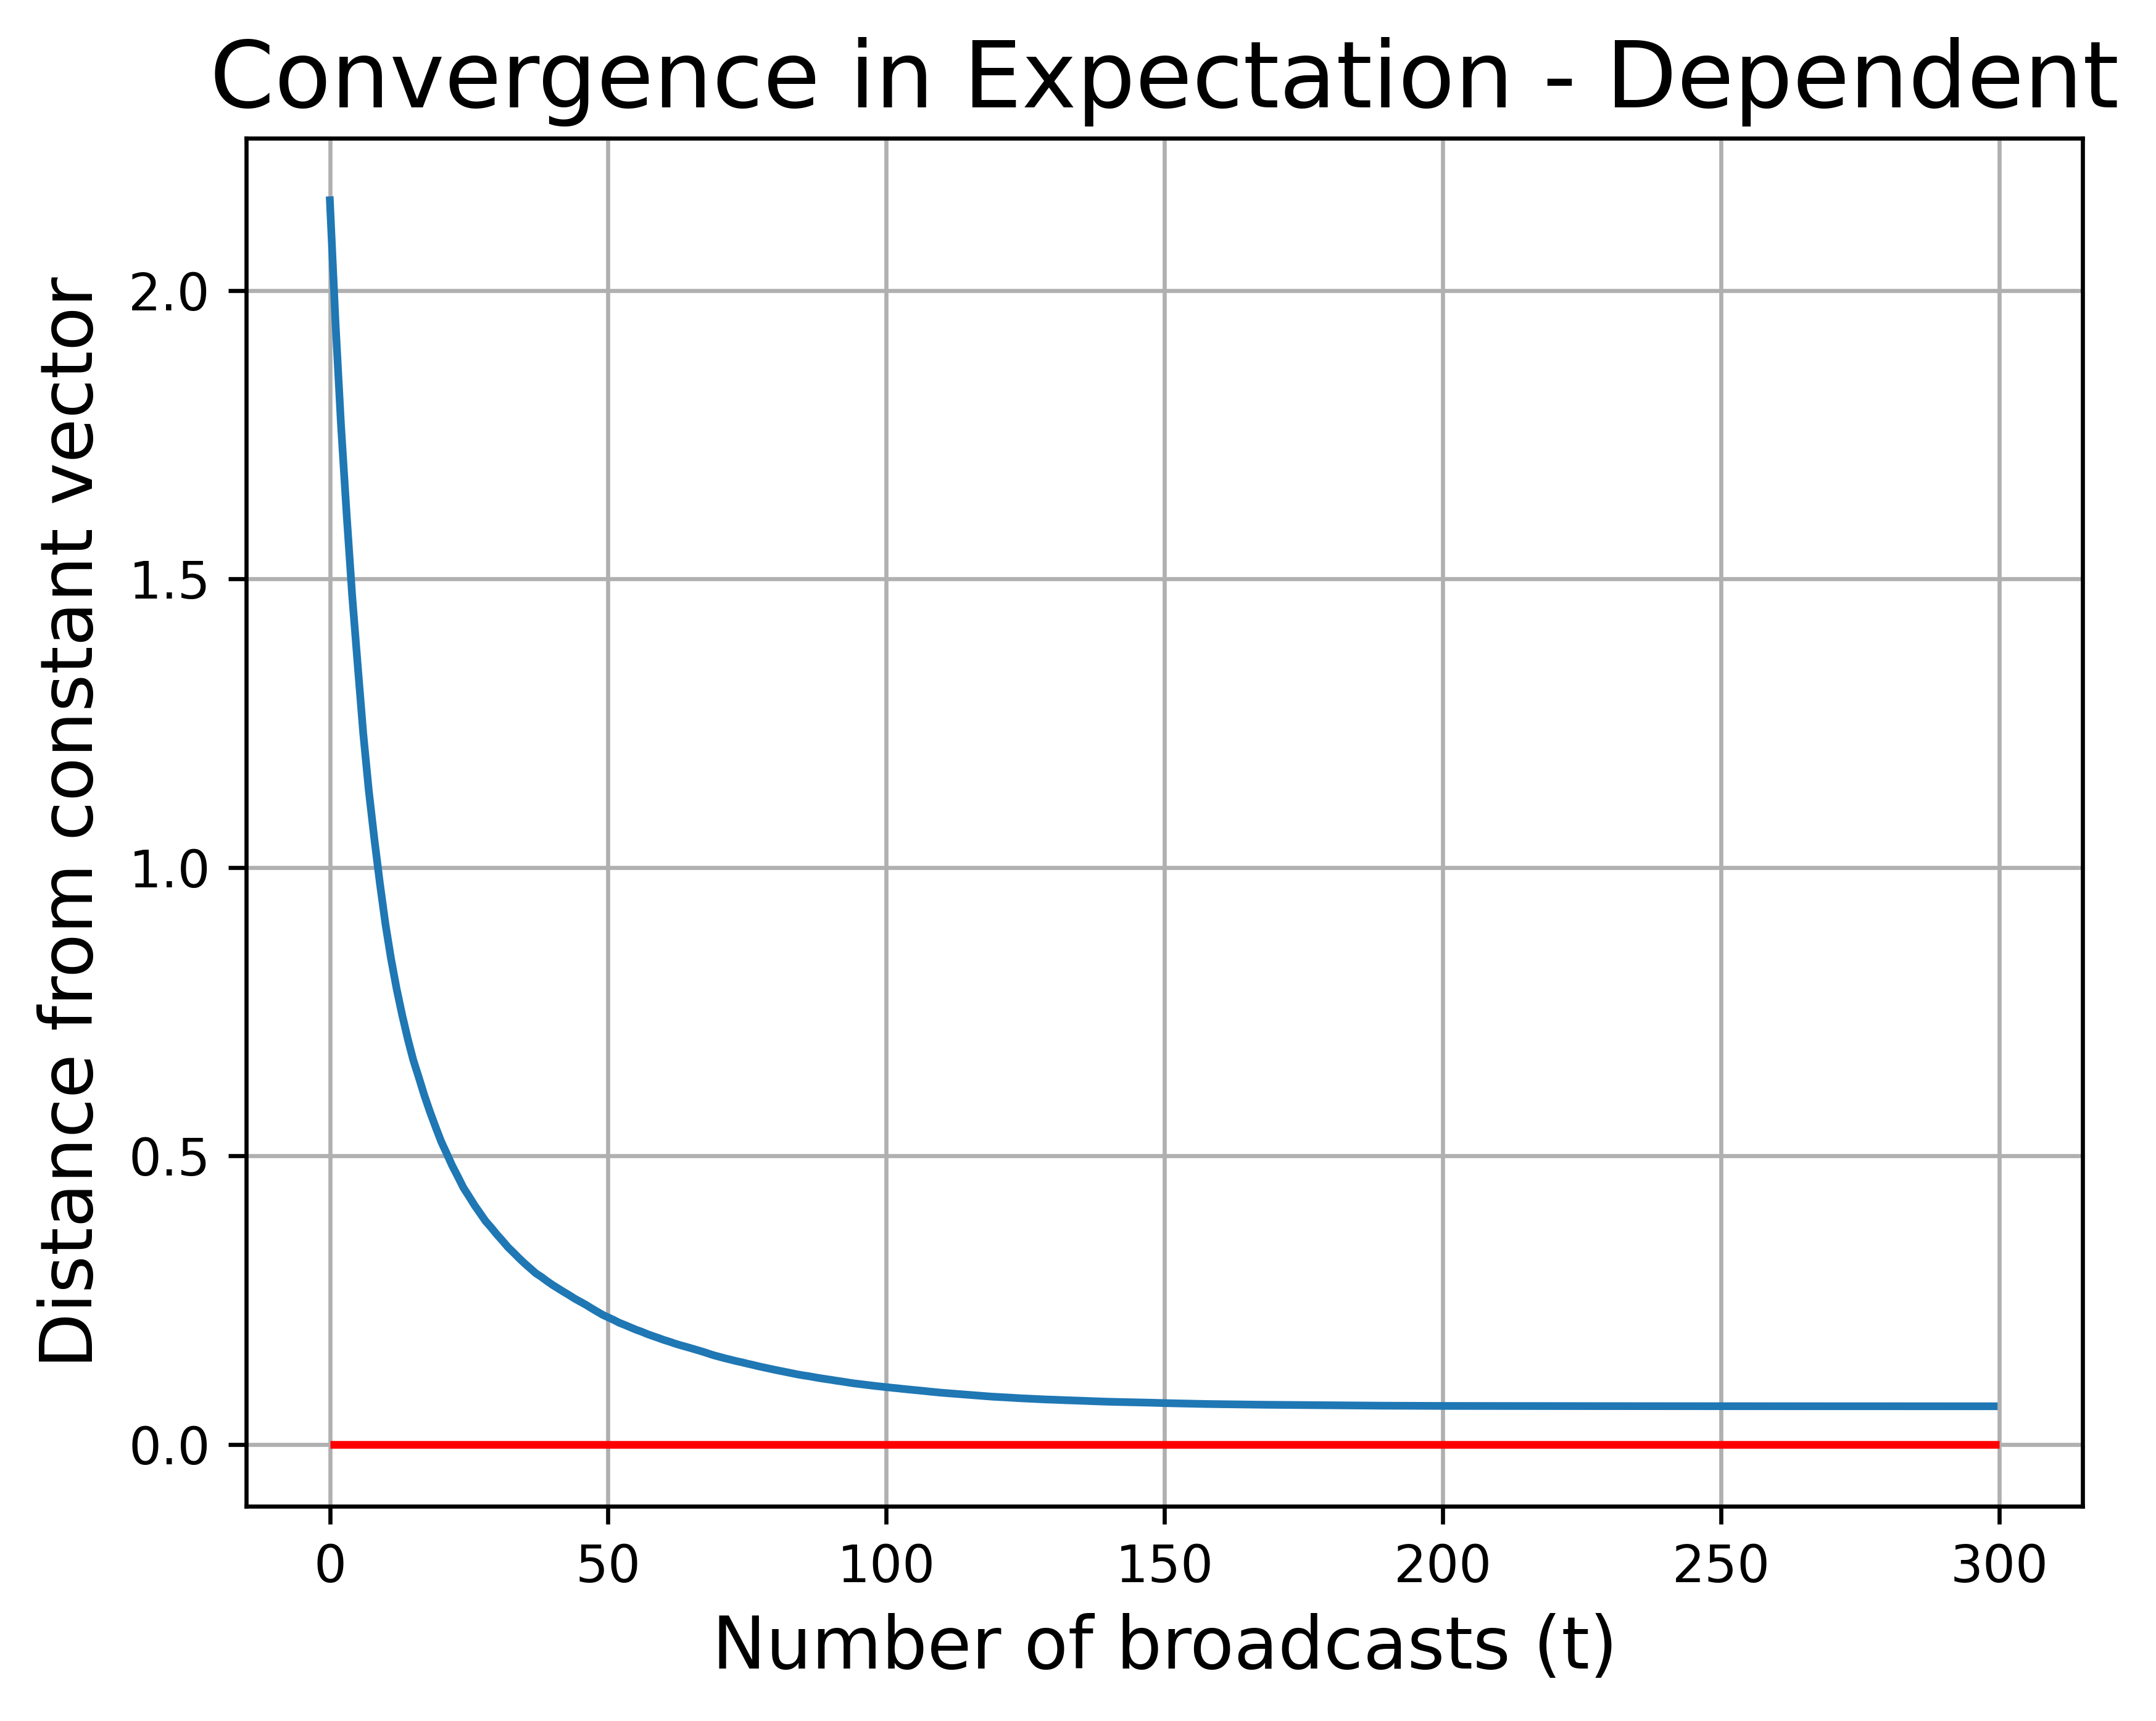

In [258]:
# Convergence in expectation plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(t_array[0:300], plot_vals_dep_1[0:300])
ax.hlines(0, 0, 300, colors='r')
ax.grid(True)
ax.set_xlabel("Number of broadcasts (t)", fontsize=14)
ax.set_ylabel("Distance from constant vector", fontsize=14)
ax.set_title("Convergence in Expectation - Dependent", fontsize=18)
fig.set_dpi(600)

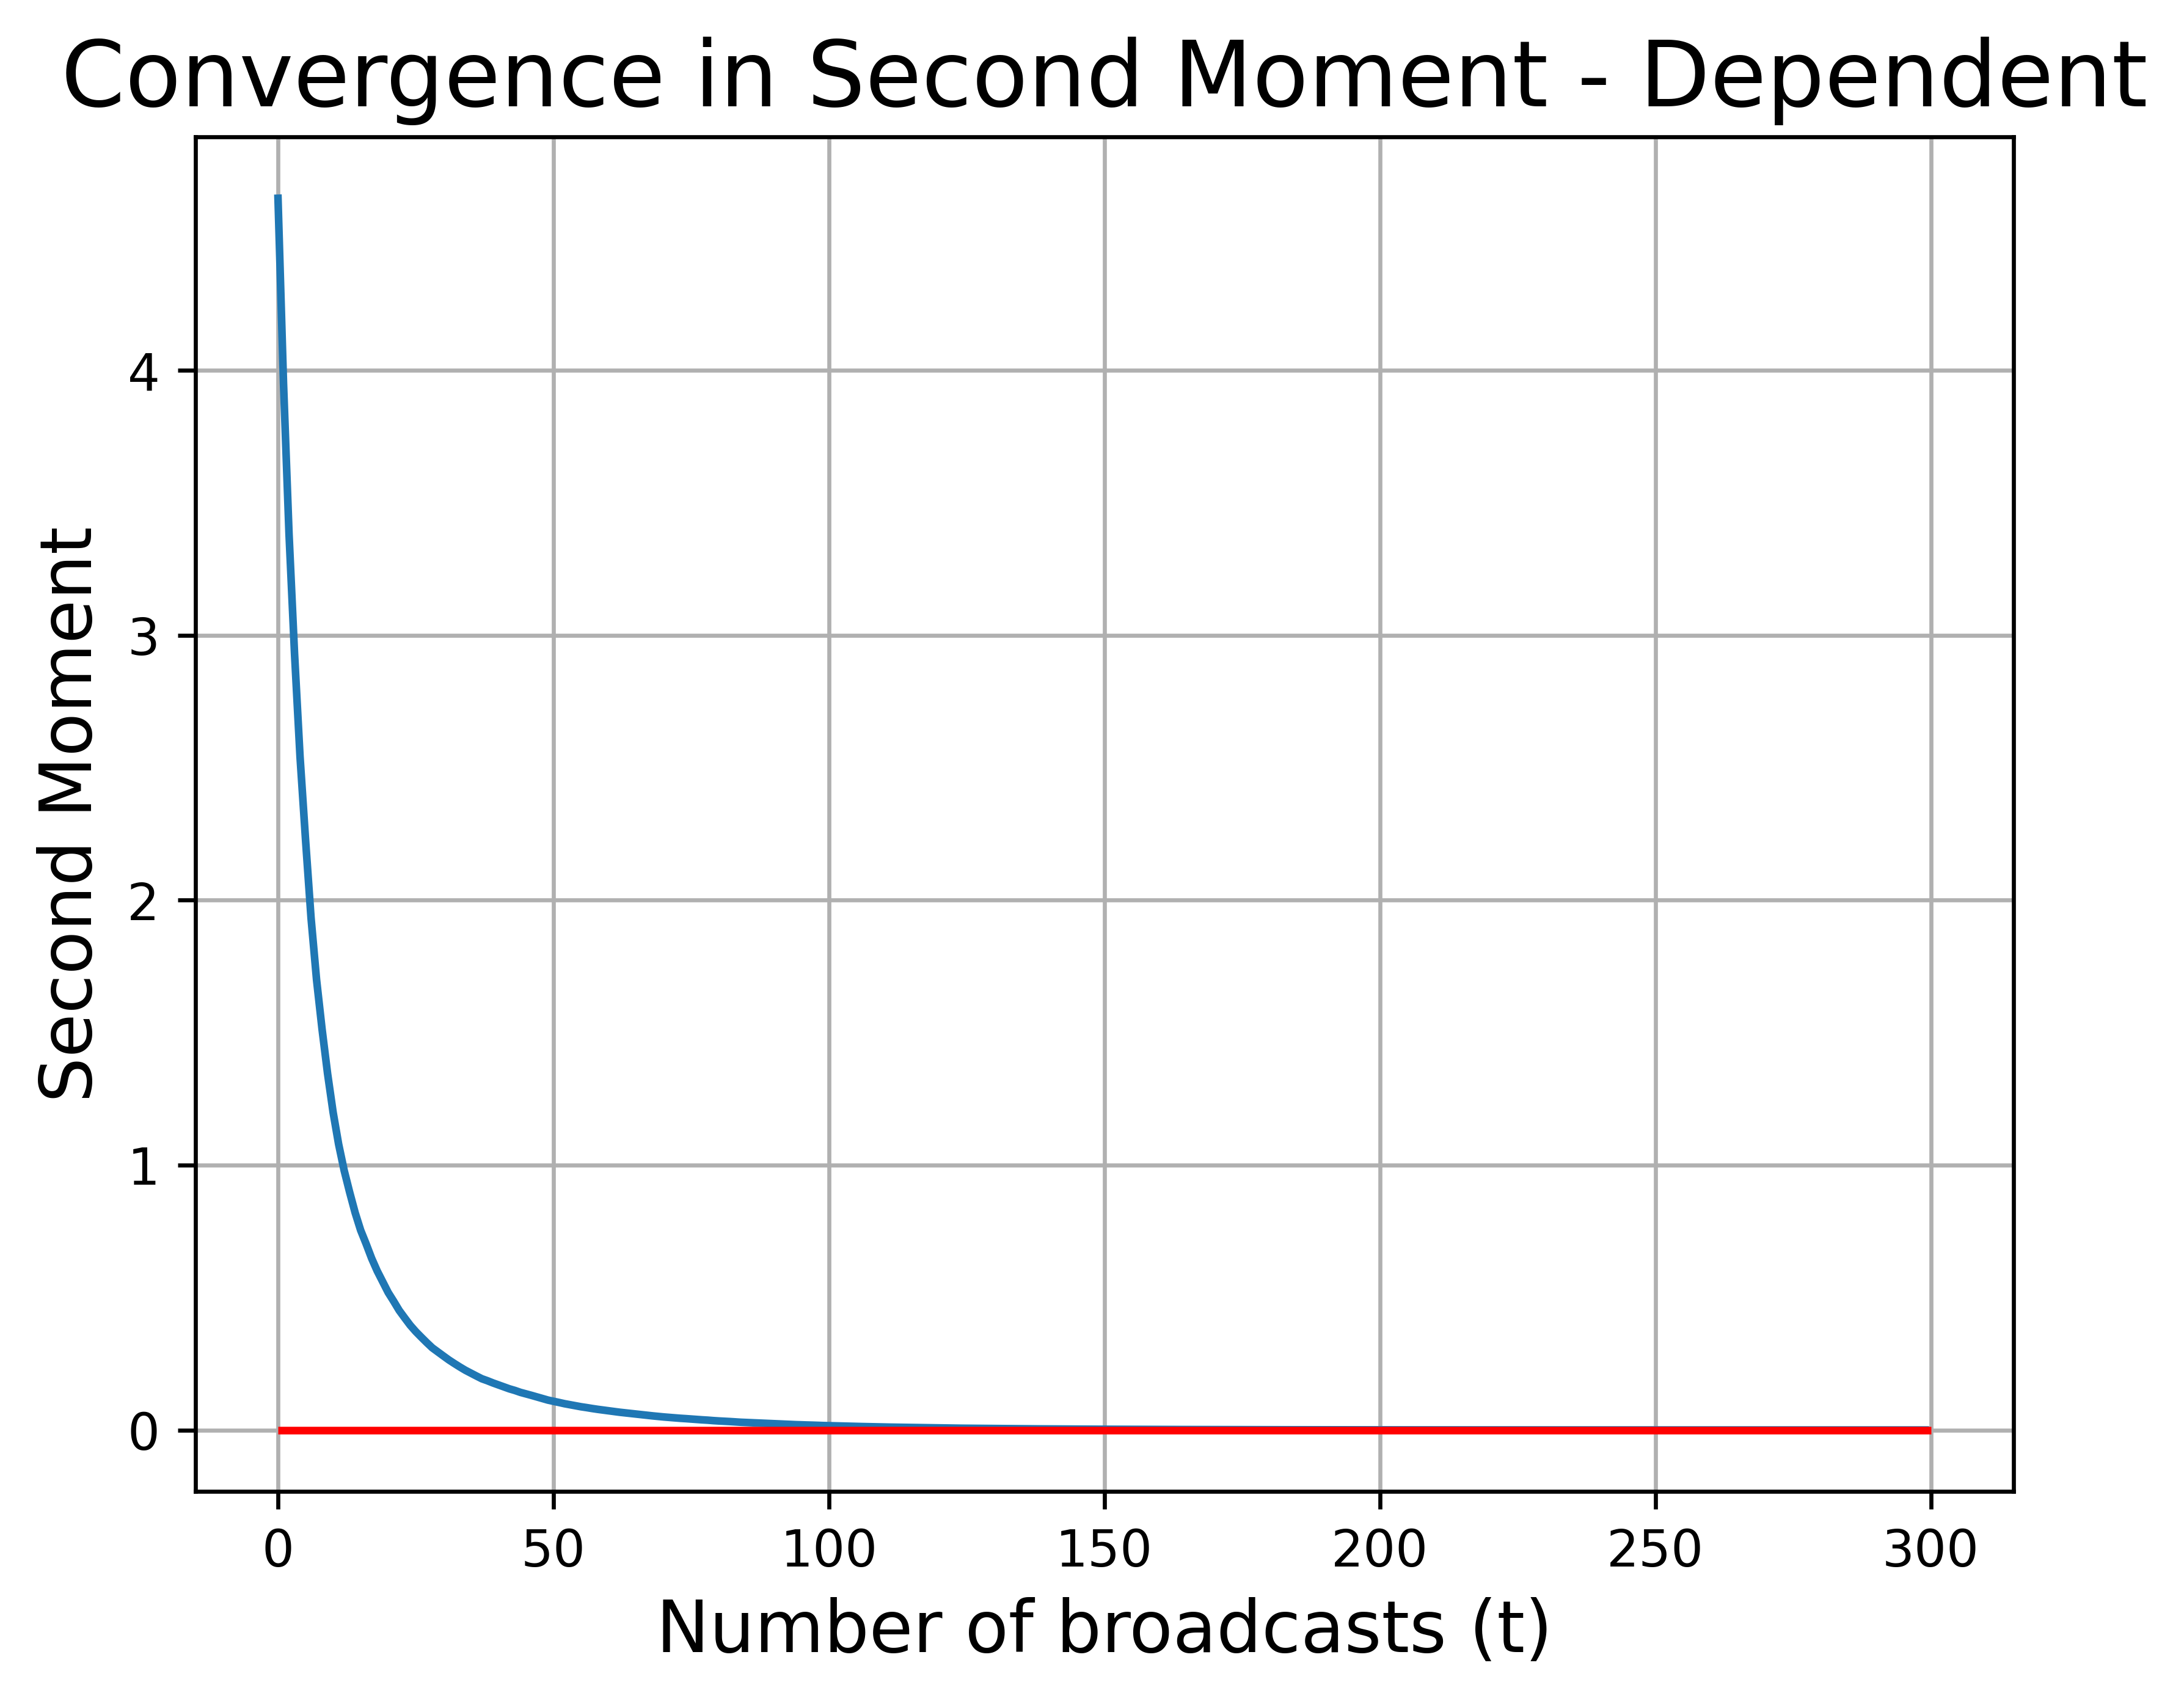

In [259]:
#Convergence in second moment plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(t_array[0:300], plot_vals_dep_2[0:300])
ax.hlines(0, 0, 300, colors='r')

ax.grid(True)
ax.set_xlabel("Number of broadcasts (t)", fontsize=14)
ax.set_ylabel("Second Moment", fontsize=14)
ax.set_title("Convergence in Second Moment - Dependent", fontsize=18)
fig.set_dpi(600)

## Communication Cost Study

In [255]:
N = 50
R = np.sqrt(np.log(N)/N)
time = 1000
gam = 1
gamma = 0.5

node_list = N_node_gen(N)
adj_mat = adj_mat_gen(node_list, R)

G = nx.from_numpy_array(adj_mat)
gam_dict = nx.pagerank(G)

maxval = max(gam_dict.values())
gam_dict = {key: value/maxval for key, value in gam_dict.items()}

x_0 = np.random.random(N)

In [256]:
#The following generates data for investigating communication cost

import numpy as np

k = 15

steps = np.arange(100, k*100+1, 100)
per_node_var_original = np.zeros(steps.shape, dtype=np.longdouble)
per_node_var_weighted = np.zeros(steps.shape, dtype=np.longdouble)
per_node_var_indep = np.zeros(steps.shape, dtype=np.longdouble)
per_node_var_dep = np.zeros(steps.shape, dtype=np.longdouble)

x_0 = np.random.random(N)
J = 1/N * np.ones((N, N))

for _ in range(0, 100):
    for i in range(0, k):
        output = original_simulate(x_0, adj_mat, gamma, steps[i])[-1]
        per_node_var_original[i] +=np.linalg.norm(output - J @ output)**2 / N
        output_1 = simulate(x_0, adj_mat, gamma, steps[i])[-1]
        per_node_var_weighted[i] += np.linalg.norm(output_1 - J @ output_1)**2 / N
        output_2 = indep_stoch_sim(x_0, adj_mat, gam, steps[i])[-1]
        per_node_var_indep[i] += np.linalg.norm(output_2 - J @ output_2)**2 / N
        output_3 = dep_stoch_sim(x_0, adj_mat, gam_dict, steps[i])[-1]
        per_node_var_dep[i] += np.linalg.norm(output_3 - J @ output_3)**2 / N

per_node_var_original /= 100
per_node_var_weighted /= 100
per_node_var_indep /= 100
per_node_var_dep /= 100

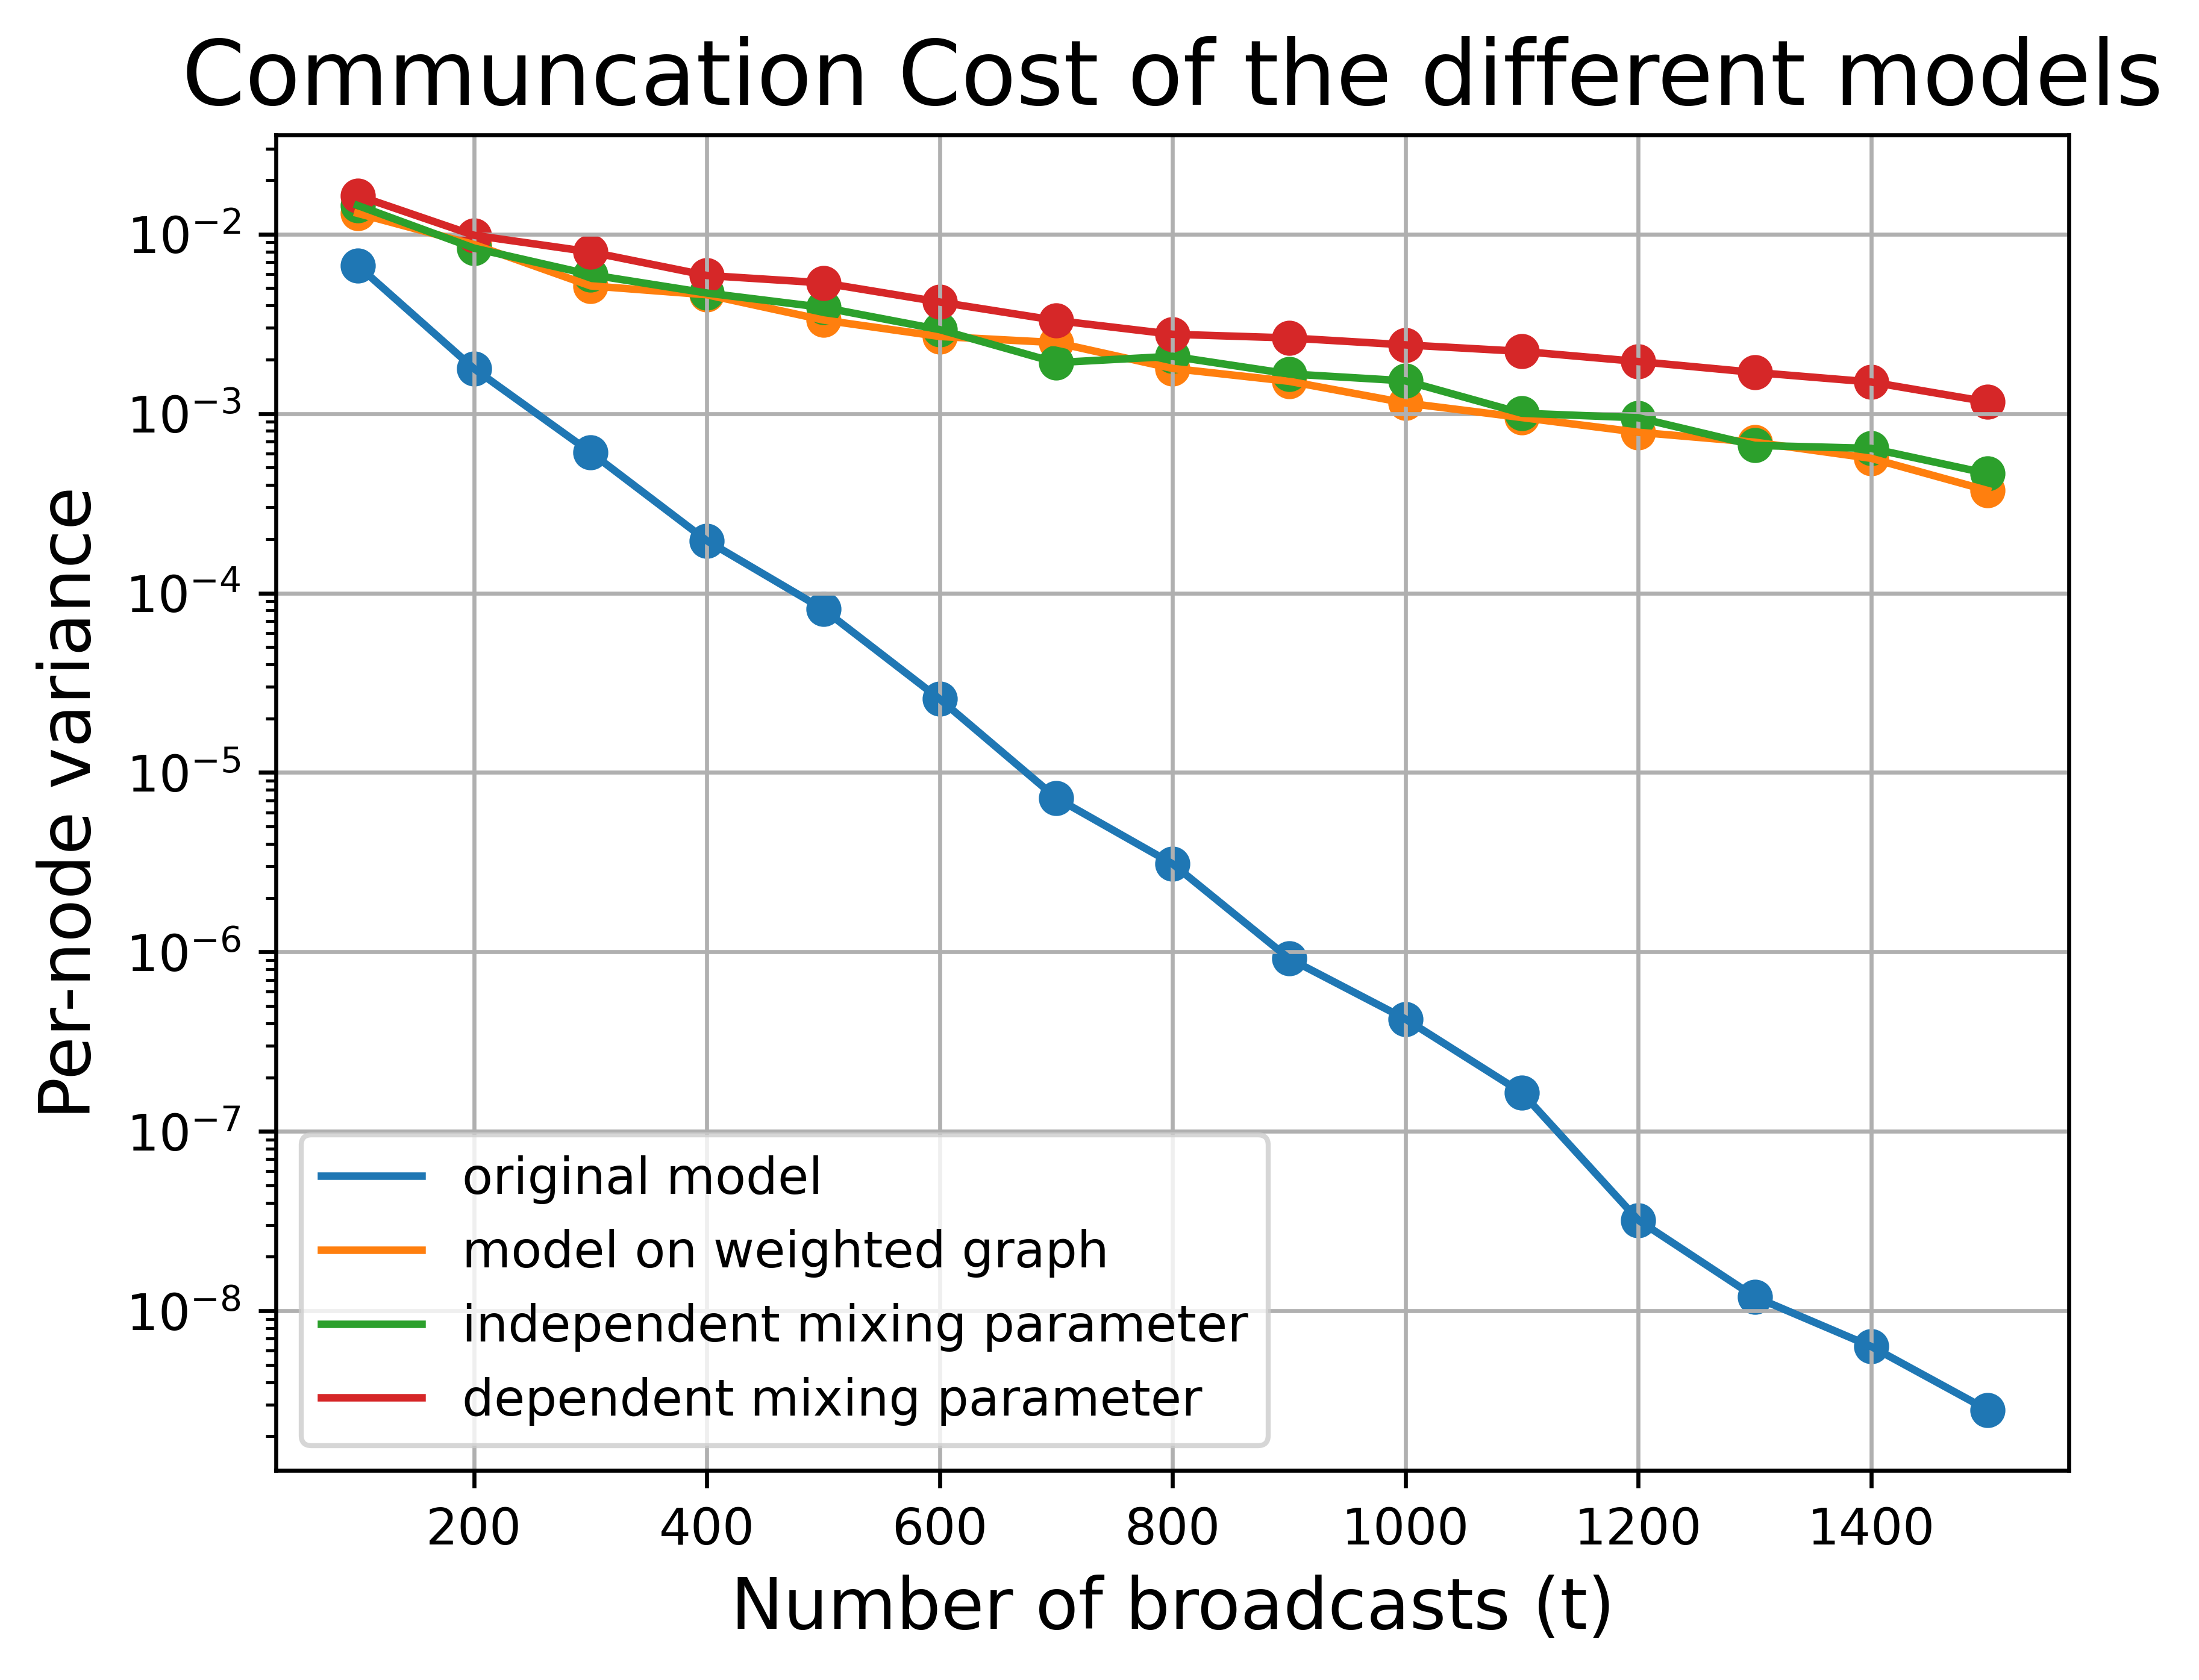

In [257]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.semilogy(steps, per_node_var_original, label="original model")
ax.scatter(steps, per_node_var_original)

ax.semilogy(steps, per_node_var_weighted, label="model on weighted graph")
ax.scatter(steps, per_node_var_weighted)

ax.semilogy(steps, per_node_var_indep, label="independent mixing parameter")
ax.scatter(steps, per_node_var_indep)

ax.semilogy(steps, per_node_var_dep, label = "dependent mixing parameter")
ax.scatter(steps, per_node_var_dep)

ax.legend(fontsize=10)

ax.grid(True)
ax.set_xlabel("Number of broadcasts (t)", fontsize=14)
ax.set_ylabel("Per-node variance", fontsize=14)
ax.set_title("Communcation Cost of the different models", fontsize=18)

fig.set_dpi(600)